# DAML notes
## Week 10 - Deep neural networks

In [1]:
# RUN THIS CELL FIRST

# Imports
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# sklearn
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier

# Kill convergence warnings
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

# This makes matplotlib output nice figures without much tweaking
plt.rcParams.update(
    {
        "lines.markersize": 10,  # Big points
        "font.size": 15,  # Larger font
        "xtick.major.size": 5.0,  # Bigger xticks
        "ytick.major.size": 5.0,  # Bigger yticks
    }
)

<hr style="border:2px solid black"> </hr>

We now move on to the topic that is responsible for most of the current hype in machine learning. When someone in the media refers to "AI", they usually mean an (artificial) neural network. Although you're about to find out that neural networks are pretty mundane in form!

> Neural networks are often called **deep** neural networks (**DNNs**). The *deep* refers to the fact that these comprise of many *layers* of processing (and because *deep* is a buzzword) and the *neural* is because of an extremely tenuous connection to how biological neurons work in the brain (and because *neural* is a buzzword).

### 10.1 Feature learning


For classification and regression we have predominantly considered linear models of the form 

\begin{equation}f(\mathbf{x}) = \mathbf{w}^\top \phi(\mathbf{x}) + b\end{equation}

where:

- $\mathbf{x}\in\mathbb{R}^D$ and $f(\mathbf{x})\in\mathbb{R}$
- $\phi$ is a transformation that maps $\mathbf{x}$ to a feature vector $\phi({\mathbf{x}})\in\mathbb{R}^{Z}$ 
- $\mathbf{w}\in \mathbb{R}^{Z}$ and $b\in\mathbb{R}$

This setup is appropriate for regression to one dimensional outputs or for binary classification. If however, we want to perform regression to multidimensional outputs or perform multiway classification then we can write a linear model more generally as:

\begin{equation}f(\mathbf{x}) = \mathbf{W} \phi(\mathbf{x}) + \mathbf{b}\end{equation} 

where:

- $\mathbf{x}\in\mathbb{R}^D$ and $f(\mathbf{x})\in\mathbb{R}^{K}$
- $\phi$ is a transformation that maps $\mathbf{x}$ to a feature vector $\phi({\mathbf{x}})\in\mathbb{R}^{Z}$ 
- $\mathbf{W}\in \mathbb{R}^{Z\times K}$ and $b\in\mathbb{R}^K$

The features we use are very important! Before DNNs became mainstream there was a lot of hand-engineering of (terrible) features. DNNs give us a model framework where we can learn features directly from data. We effectively have a parameterised feature transformation:

\begin{equation}f(\mathbf{x}) = \mathbf{W} \phi_{\boldsymbol\theta_f}(\mathbf{x}) + \mathbf{b}\end{equation}

For some loss $L$ with a linear model we would solve $\underset{\mathbf{W},\mathbf{b}}{\mathrm {minimise}}\,L$. With a DNN we instead solve $\underset{\boldsymbol\theta_f,\mathbf{W},\mathbf{b}}{\mathrm {minimise}}\,L$. This means we learn a feature transformation jointly with learning the linear transformation that is applied to those features.

So what does $\phi_{\boldsymbol\theta}(\mathbf{x})$ look like? We will consider the simplest DNN - **the multilayer perceptron (MLP)** - where $\phi_{\boldsymbol\theta}(\mathbf{x})$ is a series of linear transformations, each followed by an *activation function*. 



### 10.2 Multilayer perceptrons (MLPs)

**A linear transformation** takes in a vector $\mathbf{h}^{(l-1)}\in\mathbb{R}^{N_{l-1}}$, pre-multiplies it by a weight matrix $\mathbf{W}^{(l)}\in\mathbb{R}^{N_{l-1}\times N_{l}}$ and adds a bias vector $\mathbf{b}^{(l)}\in\mathbb{R}^{N_l}$ to give us a vector $\mathbf{a}^{(l)}\in\mathbb{R}^{N_{l}}$

\begin{equation} \mathbf{a}^{(l)} = \mathbf{W}^{(l) }\mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}\end{equation}



**An activation function** takes in a vector and applies a non-linear function to each element of that vector. The most common function used for this is a RELU (rectified linear unit) $\mathrm{RELU}(a) = \max(a,0)$. This simply sets negative elements of the incoming vector to zero, e.g.

\begin{equation}\mathrm{RELU}(\begin{bmatrix}5 \\ -4 \\ -1 \\ 7 \end{bmatrix})=\begin{bmatrix}5 \\ 0 \\ 0 \\ 7 \end{bmatrix} \end{equation}




Each linear transform + activation function pair is referred to as a **layer**. The output of a layer is referred to as an **activation**. The input to the activation function is referred to as a **pre-activation**.

When counting layers we typically include the final linear transformation too.

If we denote $\mathbf{x}$ as $\mathbf{h}^{(0)}$, and the activation function as $g$ then we can write an $\mathcal{L}$ layer MLP as:

\begin{equation}\mathbf{h}^{(l)} = g(\mathbf{W}^{(l) }\mathbf{h}^{(l-1)} + \mathbf{b}^{(l)}) \,\,\text{for}\,\,l=1,2,\dots,\mathcal{L}-1\end{equation}

\begin{equation}f(\mathbf{x})=  \mathbf{W}^{(\mathcal{L})}\mathbf{h}^{(\mathcal{L}-1)} + \mathbf{b}^{(\mathcal{L})}\end{equation}

> Note that the final layer needn't always be linear. For instance, if you we regressing to a value that you knew could only be between 0 and 1 you could pump the output through a sigmoid.


We can compare this second equation to the $f(\mathbf{x})$ above to see that our feature $\phi_{\boldsymbol\theta_f}(\mathbf{x})$ for an input $\mathbf{x}$ is the output of the penultimate layer ($\mathbf{h}^{(\mathcal{L}-1)}$) and that $\boldsymbol\theta_f$ consists of the weight matrices and bias vectors of all the MLP layers apart from the last. We can store all our parameters into one array $\boldsymbol\theta= \{\boldsymbol\theta_f,\mathbf{W}^{(\mathcal{L})},\mathbf{b}^{(\mathcal{L})}\}$ for notational convenience.


### 10.3 Learning the parameters of an MLP

Let's say we have a training set $\{(\mathbf{x}^{(n)}, \mathbf{y}^{(n)})\}_{n=1}^{N}$, where for classification each $\mathbf{y}$ is a one-hot class label and for regression is some vector of continuous values.

The problem of learning the parameters of an MLP is $\underset{\boldsymbol\theta}{\mathrm {minimise}}\ L$ where $\boldsymbol\theta =\Big\{\mathbf{W}^{(l)},\mathbf{b}^{(l)} \Big\}_{l=1}^{\mathcal{L}}$

For classification $L$ is typically the log loss 

\begin{equation}L_{log} = \frac{1}{n}\sum_{n} -\mathbf{y}^{(n)\top}\log S (f(\mathbf{x}^{(n)}))\end{equation}

where $S$ is the softmax function. For regression, $L$ is typically mean squared error (MSE).

\begin{equation}L_{MSE} =\frac{1}{N} \sum_n \lVert \mathbf{y}^{(n)} - f(\mathbf{x}^{(n)})\rVert^2\end{equation}

Note that this is slightly different to the MSE you saw in the 1D output case.

We will solve this optimisation problem with a gradient-based optimiser. Specifically, we will iteratively use the backpropagation algorithm (which is really just the chain rule!) to collect the gradients of the loss wrt. all the weight matrices and bias vectors:

\begin{equation}\nabla_{\boldsymbol\theta}L =\Big\{\Big(\frac{\partial L}{\partial \mathbf{W}^{(l)}}\Big)^\top  ,\Big(\frac{\partial L}{\partial \mathbf{b}^{(l)}}\Big)^\top \Big\}_{l=1}^{\mathcal{L}}\end{equation}

and use these to perform updates. While I did give some more detail about backpropagation in the lecture, this is all you need to know for this course.


In practice, MLPs are optimised using stochastic gradient descent (or a variant of it called [Adam](https://arxiv.org/abs/1412.6980)) where at each step, a **mini-batch** of data points is used to approximate the gradients for the whole dataset. This is mainly because computing gradients requires storing activations, which is prohibitively expensive for a large dataset.

> It's worth being aware that neither of the above losses are convex when our model is an MLP. However, we often find that we end up in a local minima which is good enough for the job.


### 10.4 MLPs in sklearn

We'll now investigate fitting MLPs in sklearn on a toy training set, which is created and plotted using the code below.

Text(0, 0.5, '$x_2$')

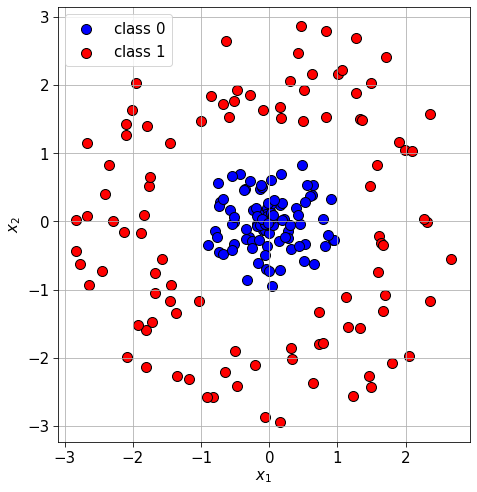

In [2]:
# Generate points from a circle

np.random.seed(42)
radii = np.hstack(
    [np.random.uniform(0, 1, size=100), np.random.uniform(1.5, 3, size=100)]
)
theta = np.random.uniform(0, 2 * np.pi, size=200)

X = np.zeros((200, 2))
X[:, 0] = radii * np.sin(theta)
X[:, 1] = radii * np.cos(theta)

y = np.hstack([np.zeros(100), np.ones(100)])

# Now let's plot our data, with a different colour for each class
fig, ax = plt.subplots(figsize=[8, 8])
ax.set_aspect("equal", "box")
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", edgecolor="k")
ax.grid()
ax.legend(["class $0$", "class $1$"])
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")

This is a binary classification problem and the training data is clearly not separable. Let's briefly fit a linear model and draw its decision boundary to see how unsuitable it is.

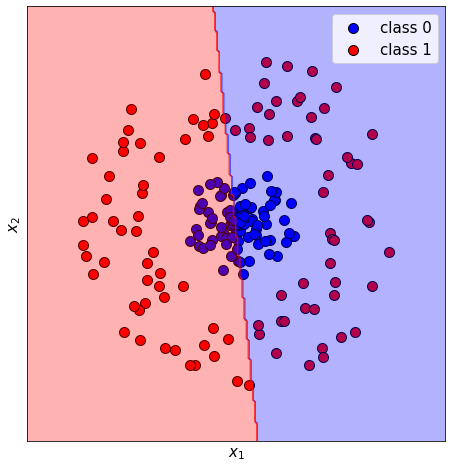

In [3]:
# Fit logistic regression
model = LogisticRegression().fit(X, y)

# Make plot
fig, ax = plt.subplots(figsize=[8, 8])
ax.set_aspect("equal", "box")
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", edgecolor="k")
ax.grid()
ax.legend(["class $0$", "class $1$"])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="upper right")
ax.set_xticks([])
ax.set_yticks([])
colours = ["b", "r"]

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=200,
    cmap=ListedColormap(colours),
    ax=ax,
)

Ouch. Let's fit an MLP instead. We can use [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) for this. By default, the model will be a 2 layer MLP (i.e. an MLP with 1 hidden layer) with hidden width of 100 that uses ReLU activations:

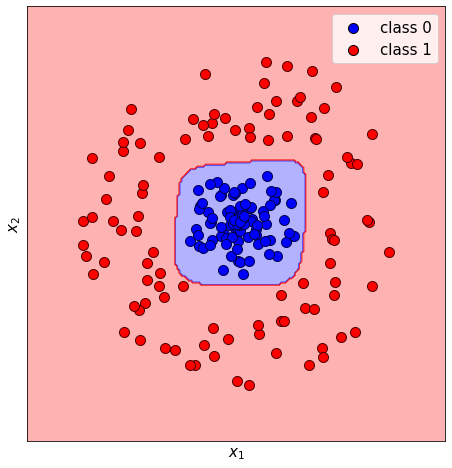

In [4]:
# Fit logistic regression
model = MLPClassifier(random_state=42).fit(X, y)

# Make plot
fig, ax = plt.subplots(figsize=[8, 8])
ax.set_aspect("equal", "box")
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", edgecolor="k")
ax.grid()
ax.legend(["class $0$", "class $1$"])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="upper right")
ax.set_xticks([])
ax.set_yticks([])
colours = ["b", "r"]

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=200,
    cmap=ListedColormap(colours),
    ax=ax,
)

This is much better, but the decision boundary could be more circular. Let's create a 3 layer MLP. We can do this by setting `hidden_layer_sizes=[100, 100]`. This tells us the MLP has 2 hidden layers, each with a width of 100 (so 3 layers in total). 

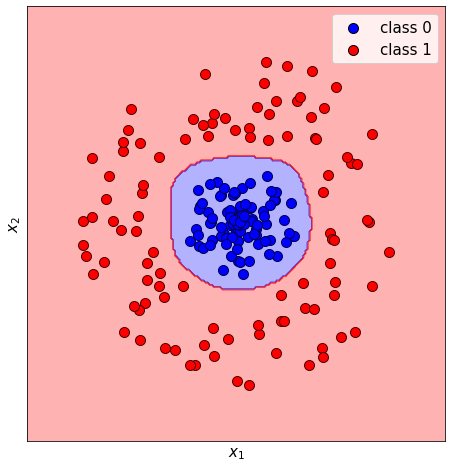

In [5]:
# Fit logistic regression
model = MLPClassifier(hidden_layer_sizes=[100, 100], random_state=42).fit(X, y)

# Make plot
fig, ax = plt.subplots(figsize=[8, 8])
ax.set_aspect("equal", "box")
ax.scatter(X[y == 0, 0], X[y == 0, 1], color="b", edgecolor="k")
ax.scatter(X[y == 1, 0], X[y == 1, 1], color="r", edgecolor="k")
ax.grid()
ax.legend(["class $0$", "class $1$"])

ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
plt.legend(["class 0", "class 1"], loc="upper right")
ax.set_xticks([])
ax.set_yticks([])
colours = ["b", "r"]

# Plot decision boundary
disp = DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    response_method="predict",
    alpha=0.3,
    grid_resolution=200,
    cmap=ListedColormap(colours),
    ax=ax,
)

That's better. You will explore the effect on changing the number of hidden layers and their widths on MNIST in the lab.

<hr style="border:2px solid black"> </hr>

#### Written by Elliot J. Crowley and &copy; The University of Edinburgh 2022-24